# Experiment 12 attention map visualization

In [1]:
import random

import torch
import matplotlib.pyplot as plt

from arithmetic_lm.model import TransformerDecoder, generate
from arithmetic_lm.tokenizer import CharTokenizer
from arithmetic_lm.interp import plot_attn_maps, merge_heads_across_layers, plot_module
from arithmetic_lm.constants import PLOTS_DIR

import warnings

warnings.filterwarnings("ignore")

/Users/imran/Desktop/studies/thesis/msc_thesis/arithmetic_lm/interp/attn_maps.py:131: SyntaxWarning: invalid escape sequence '\$'
  f"{figtitle_prefix} Attention maps for prompt: {repr(prompt_str).replace('$', '\$')}, [{len(astr)}+{len(bstr)}]"
/Users/imran/Desktop/studies/thesis/msc_thesis/arithmetic_lm/interp/attn_maps.py:132: SyntaxWarning: invalid escape sequence '\$'
  f"\n predicted answer: {repr(pred_answer_str).replace('$', '\$')} ({'correct' if pred_answer_num == true_ans else 'incorrect, true: ' + true_ans})",


In [2]:
tokenizer = CharTokenizer()

In [3]:
def load_model(ckpt_path: str) -> tuple[torch.nn.Module, dict]:
    # load model
    ckpt = torch.load(ckpt_path, map_location="mps")
    model = TransformerDecoder(
        **ckpt["hyper_parameters"]["model_hparams"],
        # vocab_size=tokenizer.vocab_size,
    )
    # state dict has a prefix "model." in the key names
    model.load_state_dict({k[6:]: v for k, v in ckpt["state_dict"].items()})
    model.eval()
    return model, ckpt["hyper_parameters"]

In [4]:
# before and after phase transition
ckpt_path_before = "../checkpoints/addition-high-n-digit-variation/trans_dec_2layers_384embd_3head/step500000-train_loss1.9965-val_loss1.9776_backup.ckpt"
ckpt_path_after = "../checkpoints/addition-high-n-digit-variation/trans_dec_2layers_384embd_3head/step1054000-train_loss1.5561-val_loss1.5174.ckpt"

In [5]:
model_before, hparams = load_model(ckpt_path_before)
model_after, _ = load_model(ckpt_path_after)

In [6]:
reverse_ans = hparams["extra_hparams"]["data_format"]["reverse_ans"]
reverse_ans

False

In [7]:
module_names = [
    "transformer_encoder.layers[0].self_attn",
    "transformer_encoder.layers[1].self_attn",
]
figsize = (14, 8)

In [8]:
subdir = PLOTS_DIR / "exp_12"
subdir.mkdir(exist_ok=True)

In [9]:
def eval_answer(model: torch.nn.Module, tokenizer, prompt: str, answer: str) -> bool:
    """Return whether the model predicts the correct answer."""

    prompt_tokens = torch.tensor(tokenizer.encode(prompt))
    stop_token_id = tokenizer.encode("$")[0]

    pred_ans = generate(
        model, idx=prompt_tokens, max_new_tokens=20, stop_token=stop_token_id
    )

    pred_ans = tokenizer.decode(pred_ans[0])
    pred_ans = pred_ans.strip("$")
    return pred_ans == answer

In [10]:
# find failure cases
while True:
    a = random.randint(10**5, 10**6)
    b = random.randint(10**5, 10**6)
    prompt = f"${a}+{b}="
    true_ans = str(a + b)
    if not eval_answer(model_before, tokenizer, prompt, true_ans) and not eval_answer(
        model_after, tokenizer, prompt, true_ans
    ):
        break

print(f"prompt: {prompt}")

prompt: $725457+199543=


prompt: '$12+34=' 2+2
true_ans: 46
pred_answer: 377775222833222$
transformer_encoder.layers[0].self_attn torch.Size([1, 3, 22, 22])
transformer_encoder.layers[1].self_attn torch.Size([1, 3, 22, 22])


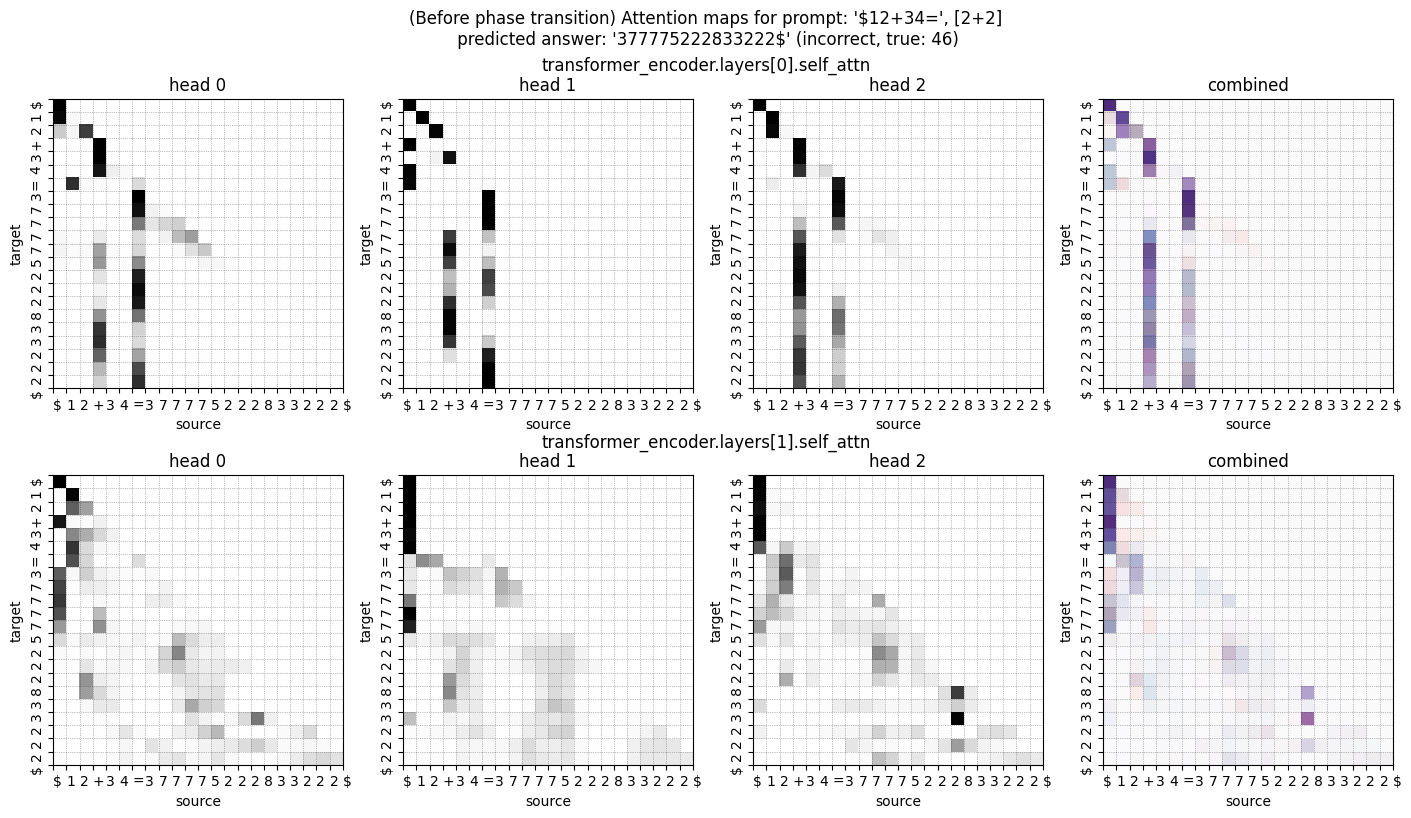

prompt: '$12+34=' 2+2
true_ans: 46
pred_answer: 1055$
transformer_encoder.layers[0].self_attn torch.Size([1, 3, 11, 11])
transformer_encoder.layers[1].self_attn torch.Size([1, 3, 11, 11])


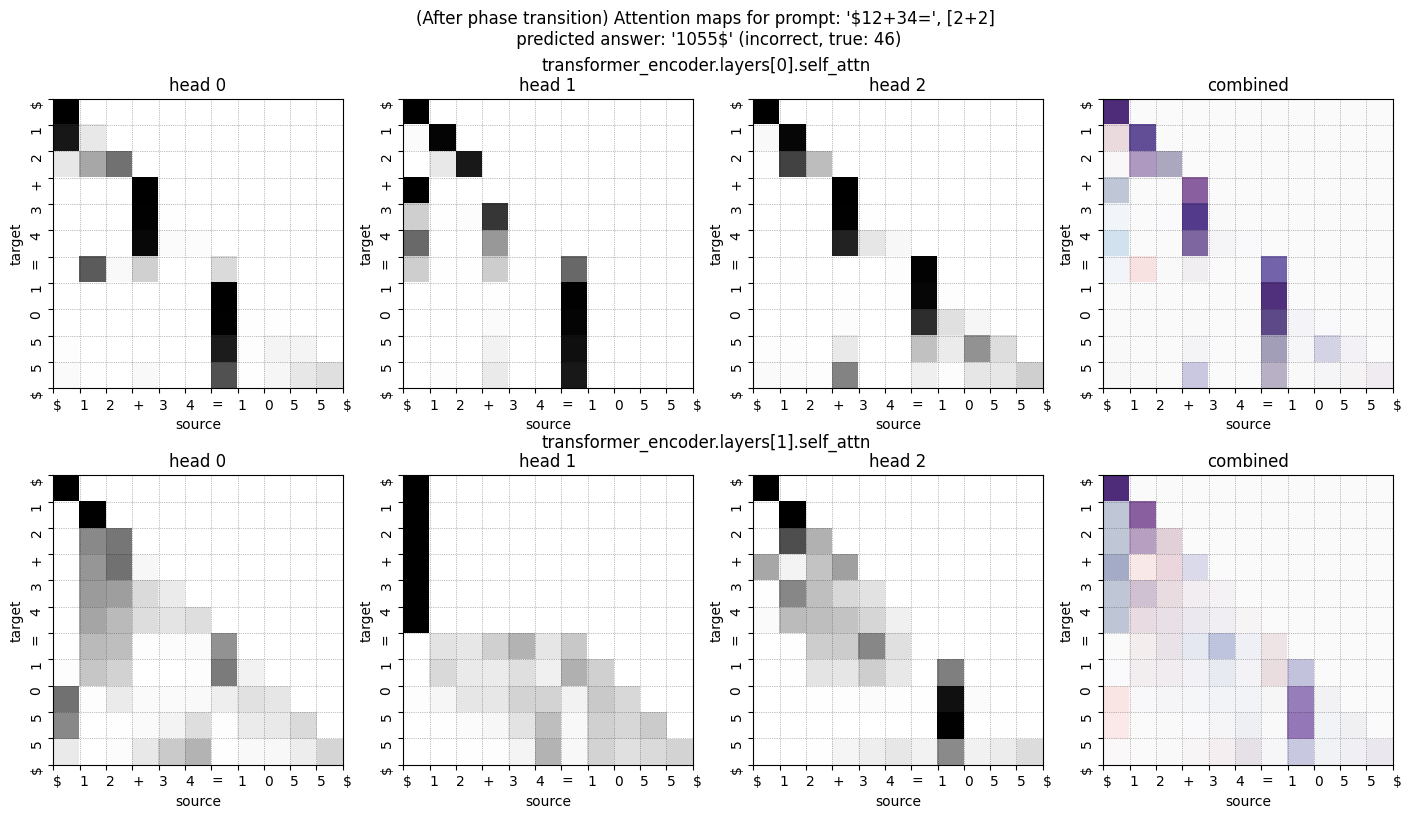

In [11]:
a, b = 12, 34
savepath = subdir / f"exp12_attention_maps_{a}+{b}.png"
kwargs = dict(
    tokenizer=tokenizer,
    a=a,
    b=b,
    module_names=module_names,
    figsize=figsize,
    reverse_ans=reverse_ans,
    # save=True,
)
plot_attn_maps(
    model=model_before,
    savepath=str(savepath).replace(".png", "_before.png"),
    figtitle_prefix="(Before phase transition)",
    **kwargs,
)
attn_maps = plot_attn_maps(
    model=model_after,
    savepath=str(savepath).replace(".png", "_after.png"),
    figtitle_prefix="(After phase transition)",
    **kwargs,
)

torch.Size([1, 3, 11, 11])


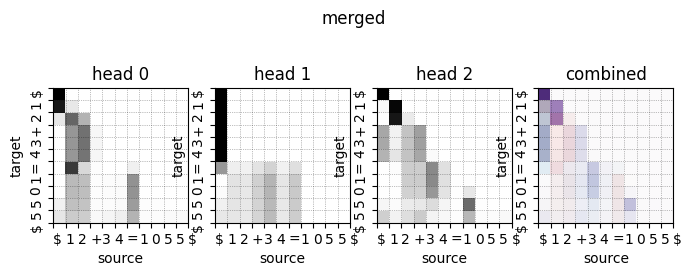

In [12]:
# merge heads and plot the resulting attention map
merged_attn_maps = merge_heads_across_layers([attn_maps[mn] for mn in module_names])
print(merged_attn_maps.shape)
fig = plt.figure(figsize=(8, 3))
plot_module(fig, "merged", merged_attn_maps, f"${a}+{b}=1055$")

torch.Size([1, 3, 11, 11])


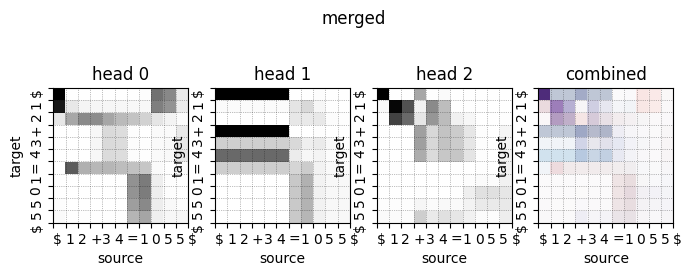

In [13]:
# merge heads and plot the resulting attention map
merged_attn_maps = merge_heads_across_layers([attn_maps[mn] for mn in module_names])
print(merged_attn_maps.shape)
fig = plt.figure(figsize=(8, 3))
plot_module(fig, "merged", merged_attn_maps, f"${a}+{b}=1055$")